#Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
from wordcloud import WordCloud

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#Data Preparation

In [2]:
ds = pd.read_csv('/content/twitter_training.csv')

In [3]:
ds.isnull().sum()

2401                                                       0
Borderlands                                                0
Positive                                                   0
im getting on borderlands and i will murder you all ,    686
dtype: int64

In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
ds.drop_duplicates(keep=False, inplace=True)

In [6]:
ds=ds.rename(columns={"2401":"id","Borderlands":"topic","Positive":"sentiment","im getting on borderlands and i will murder you all ,":"comment"})

In [7]:
ds.head()

,id,topic,sentiment,comment
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [8]:
ds["topic"].unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [9]:
ds["comment"].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
74676    False
74677    False
74678    False
74679    False
74680    False
Name: comment, Length: 69828, dtype: bool

In [10]:
ds=ds.dropna()

In [11]:
ds.isnull().sum()

id           0
topic        0
sentiment    0
comment      0
dtype: int64

In [12]:
ds["comment"].isnull().sum()

0

#Data Preprocessing

##Label Encoding Sentiments and Topic

In [13]:
encoder = LabelEncoder()
ds["sentiment"] = encoder.fit_transform(ds["sentiment"])
ds["topic"] = encoder.fit_transform(ds["topic"])

In [14]:
ds.head()

,id,topic,sentiment,comment
0,2401,4,3,I am coming to the borders and I will kill you...
1,2401,4,3,im getting on borderlands and i will kill you ...
2,2401,4,3,im coming on borderlands and i will murder you...
3,2401,4,3,im getting on borderlands 2 and i will murder ...
4,2401,4,3,im getting into borderlands and i can murder y...


##Replacing Major Punctuations

In [15]:
ds["comment"] = ds["comment"].replace(',', '').replace('!', '').replace('.', '')

In [16]:
ds["comment"]

0        I am coming to the borders and I will kill you...
1        im getting on borderlands and i will kill you ...
2        im coming on borderlands and i will murder you...
3        im getting on borderlands 2 and i will murder ...
4        im getting into borderlands and i can murder y...
                               ...                        
74676    Just realized that the Windows partition of my...
74677    Just realized that my Mac window partition is ...
74678    Just realized the windows partition of my Mac ...
74679    Just realized between the windows partition of...
74680    Just like the windows partition of my Mac is l...
Name: comment, Length: 69690, dtype: object

##Changing Text to Lowercase

In [17]:
ds["comment"]=ds["comment"].str.lower()

##Using Stemming to reduce text to base form

In [18]:
ps = PorterStemmer()

def stemmer(word):
    word = word.lower()
    word = word_tokenize(word)

    full_txt = []
    for i in word:
        if i not in "!@#$%^&*()-_=+`~;:'\",<.>/?|":
            full_txt.append(ps.stem(i))
    return ' '.join(full_txt)


In [19]:
  ds["comment"]=ds["comment"].apply(stemmer)

In [20]:
ds.head()

,id,topic,sentiment,comment
0,2401,4,3,i am come to the border and i will kill you all
1,2401,4,3,im get on borderland and i will kill you all
2,2401,4,3,im come on borderland and i will murder you all
3,2401,4,3,im get on borderland 2 and i will murder you m...
4,2401,4,3,im get into borderland and i can murder you all


#Tokenization

In [21]:
ds['tokenized'] = ds['comment'].apply(word_tokenize)

In [22]:
ds.head()

,id,topic,sentiment,comment,tokenized
0,2401,4,3,i am come to the border and i will kill you all,"[i, am, come, to, the, border, and, i, will, k..."
1,2401,4,3,im get on borderland and i will kill you all,"[im, get, on, borderland, and, i, will, kill, ..."
2,2401,4,3,im come on borderland and i will murder you all,"[im, come, on, borderland, and, i, will, murde..."
3,2401,4,3,im get on borderland 2 and i will murder you m...,"[im, get, on, borderland, 2, and, i, will, mur..."
4,2401,4,3,im get into borderland and i can murder you all,"[im, get, into, borderland, and, i, can, murde..."


In [23]:
ds['tokenized'] = ds['tokenized'].apply(lambda tokens: ' '.join(tokens))

In [24]:
token = ds["tokenized"]

#Feature Extraction

In [25]:
feature_extraction = TfidfVectorizer()
comment=feature_extraction.fit_transform(token)

In [26]:
ds.head()

,id,topic,sentiment,comment,tokenized
0,2401,4,3,i am come to the border and i will kill you all,i am come to the border and i will kill you all
1,2401,4,3,im get on borderland and i will kill you all,im get on borderland and i will kill you all
2,2401,4,3,im come on borderland and i will murder you all,im come on borderland and i will murder you all
3,2401,4,3,im get on borderland 2 and i will murder you m...,im get on borderland 2 and i will murder you m...
4,2401,4,3,im get into borderland and i can murder you all,im get into borderland and i can murder you all


In [27]:
comment

<69690x25432 sparse matrix of type '<class 'numpy.float64'>'
	with 1167802 stored elements in Compressed Sparse Row format>

#Classification using Multinomial Naive Bayes

In [28]:
y=ds["sentiment"]

In [29]:
X_train,X_test,y_train,y_test = train_test_split(comment,y,test_size=0.2,random_state=50)

In [30]:
gnb = MultinomialNB()
gnb.fit(X_train,y_train)

MultinomialNB()

#Model Evaluation

In [31]:
gnb.score(X_train,y_train)

0.7420002869852202

In [32]:
gnb.score(X_test,y_test)

0.6961543980485005

In [33]:
cv = cross_val_score(gnb,X_train,y_train)
cv

array([0.67402027, 0.67841449, 0.6793722 , 0.67829596, 0.68179372])

In [34]:
cross_val_score(gnb,X_test,y_test)

array([0.57604017, 0.56635581, 0.57675753, 0.57947614, 0.57229996])

In [35]:
cross_val_score(gnb,comment,y)

array([0.52051944, 0.45580428, 0.39625484, 0.41010188, 0.50688765])

#Data Visualization

##Data Distribution

Text(0, 0.5, 'Count')

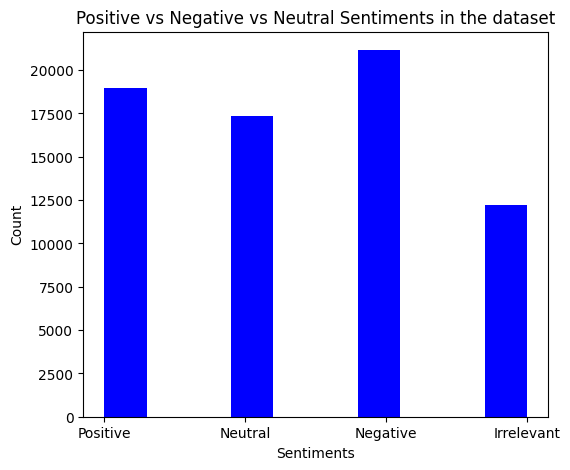

In [36]:
labelMap = {0: 'Irrelevant', 1: 'Negative', 2: 'Neutral', 3: 'Positive'}

labels = [labelMap[category] for category in y]

plt.figure(figsize=(6,5))
plt.hist(labels,color="blue")
plt.title('Positive vs Negative vs Neutral Sentiments in the dataset')
plt.xlabel('Sentiments')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

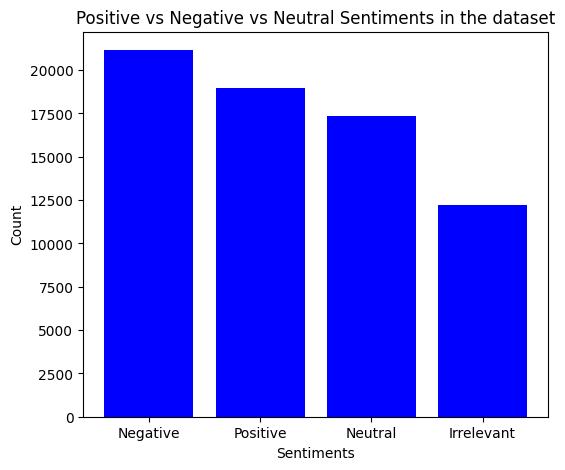

In [37]:
valueCounts = y.value_counts()

labels1 = valueCounts.index.tolist()
counts = valueCounts.values.tolist()

ls = ['Negative','Positive','Neutral','Irrelevant']

plt.figure(figsize=(6,5))
plt.bar(ls,counts,color="blue")
plt.title('Positive vs Negative vs Neutral Sentiments in the dataset')
plt.xlabel('Sentiments')
plt.ylabel('Count')

##Word Frequency Analysis

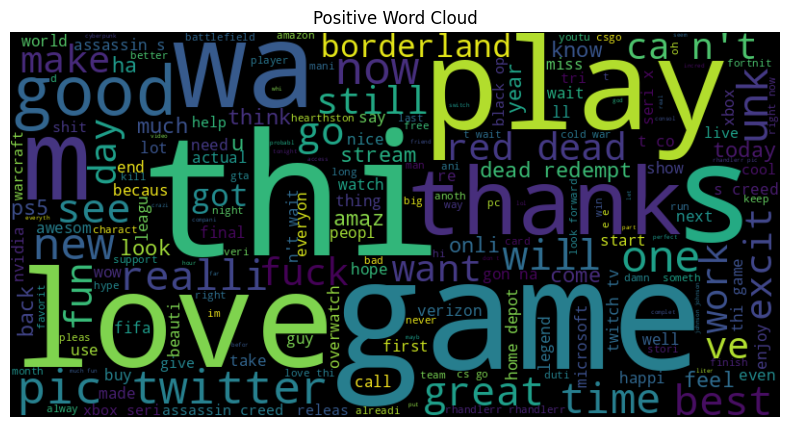

In [38]:
wordcloud = WordCloud(width=800, height=400).generate(' '.join(ds['tokenized'][ds["sentiment"]==3]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Positive Word Cloud")
plt.axis('off')
plt.show()

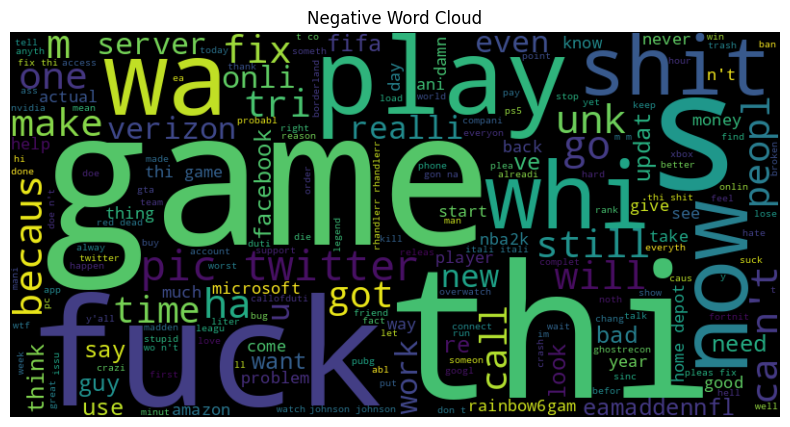

In [39]:
wordcloud = WordCloud(width=800, height=400).generate(' '.join(ds['tokenized'][ds["sentiment"]==1]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Negative Word Cloud")
plt.axis('off')
plt.show()

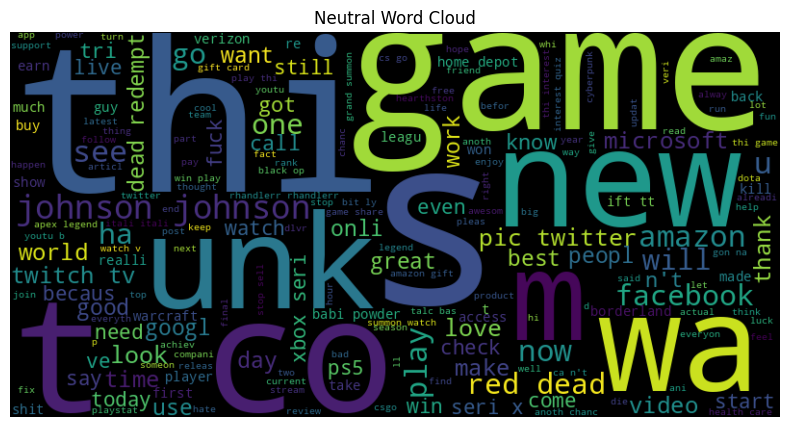

In [40]:
wordcloud = WordCloud(width=800, height=400).generate(' '.join(ds['tokenized'][ds["sentiment"]==2]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Neutral Word Cloud")
plt.axis('off')
plt.show()

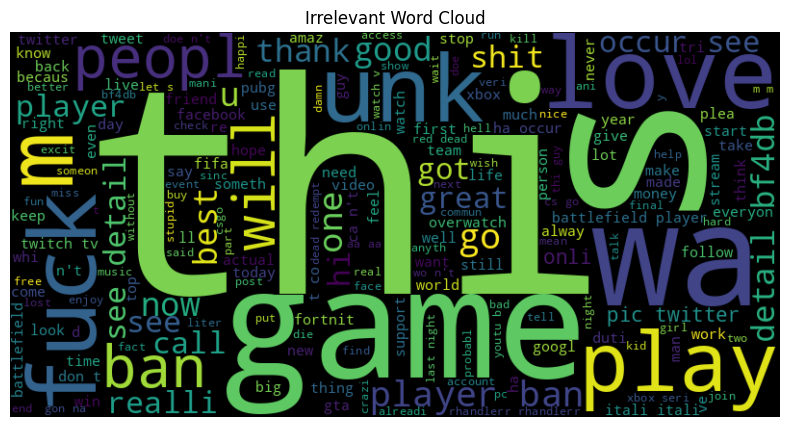

In [41]:
wordcloud = WordCloud(width=800, height=400).generate(' '.join(ds['tokenized'][ds["sentiment"]==0]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Irrelevant Word Cloud")
plt.axis('off')
plt.show()

In [42]:
pos_count = {}
for i in ds["tokenized"][ds["sentiment"]==3]:
  for j in i.split(" "):
    if(j not in pos_count):
      pos_count[j]=1
    else:
      pos_count[j]+=1
posCount = pd.DataFrame(list(pos_count.items()), columns=['Word', 'Frequency'])
topPos = posCount.nlargest(10, 'Frequency')
topPos

,Word,Frequency
4,the,11445
0,i,10997
3,to,7379
6,and,6711
22,a,5723
102,it,5297
38,of,4906
36,is,4259
27,for,4227
68,thi,4027


In [43]:
neg_count = {}
for i in ds["tokenized"][ds["sentiment"]==1]:
  for j in i.split(" "):
    if(j not in neg_count):
      neg_count[j]=1
    else:
      neg_count[j]+=1
negCount = pd.DataFrame(list(neg_count.items()), columns=['Word', 'Frequency'])
topNeg = negCount.nlargest(10, 'Frequency')
topNeg

,Word,Frequency
0,the,13783
46,i,11658
25,to,8943
56,and,8522
8,a,7371
150,is,6728
57,it,6527
80,of,5632
27,thi,4780
3,in,4713


In [44]:
neu_count = {}
for i in ds["tokenized"][ds["sentiment"]==2]:
  for j in i.split(" "):
    if(j not in neu_count):
      neu_count[j]=1
    else:
      neu_count[j]+=1
neuCount = pd.DataFrame(list(neu_count.items()), columns=['Word', 'Frequency'])
topNeu = neuCount.nlargest(10, 'Frequency')
topNeu

,Word,Frequency
21,the,10366
49,to,6966
22,i,6540
115,and,6189
44,a,5784
46,of,4800
105,...,4355
26,it,3960
67,for,3903
73,in,3874


In [45]:
irr_count = {}
for i in ds["tokenized"][ds["sentiment"]==0]:
  for j in i.split(" "):
    if(j not in irr_count):
      irr_count[j]=1
    else:
      irr_count[j]+=1
irrCount = pd.DataFrame(list(irr_count.items()), columns=['Word', 'Frequency'])
topIrr = irrCount.nlargest(10, 'Frequency')
topIrr

,Word,Frequency
1,the,7773
79,i,5290
215,to,4804
279,a,4660
6,and,4606
37,of,3536
113,is,3035
266,for,2903
256,you,2874
285,it,2802


In [46]:
ls = [topPos,topNeg,topNeu,topIrr]
idx = ['Positive','Negative','Neutral','Irrelevant']

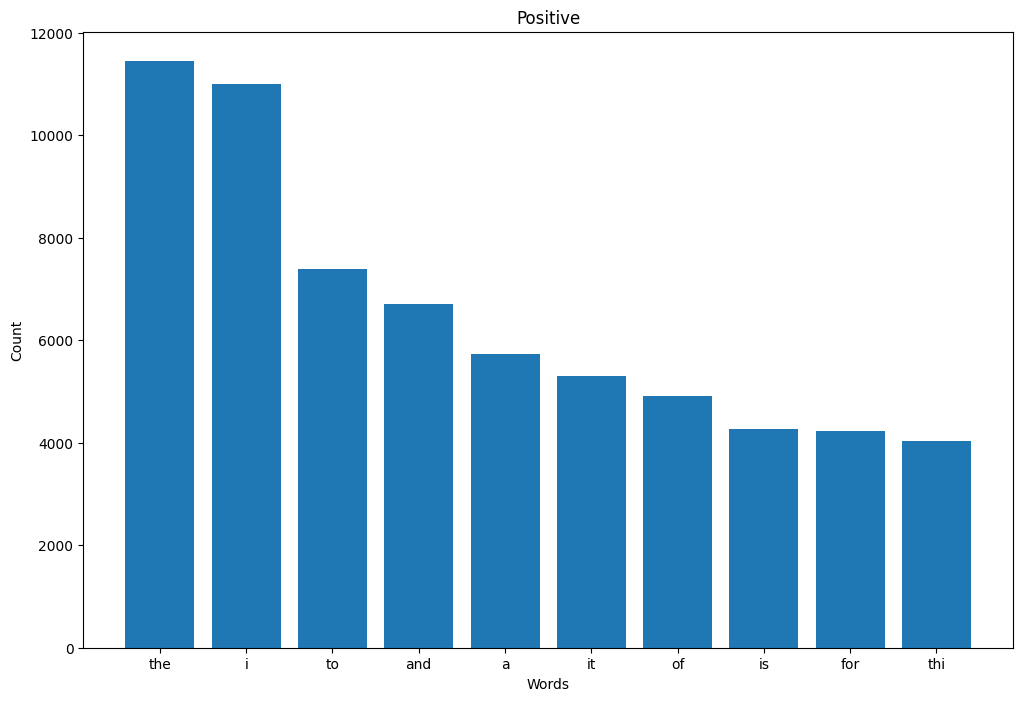

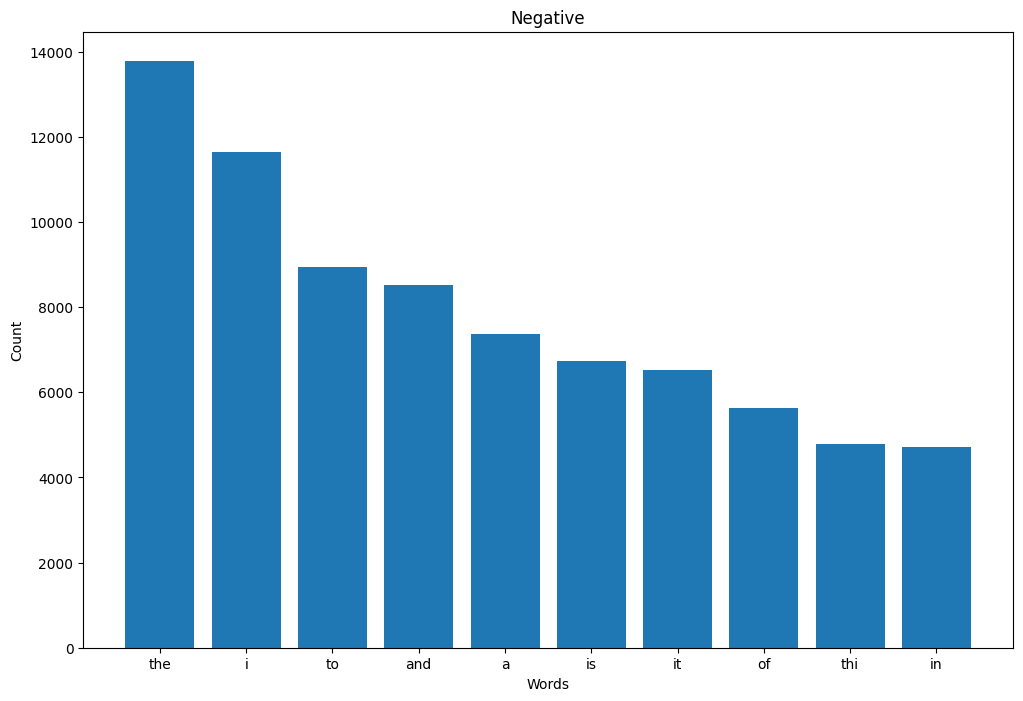

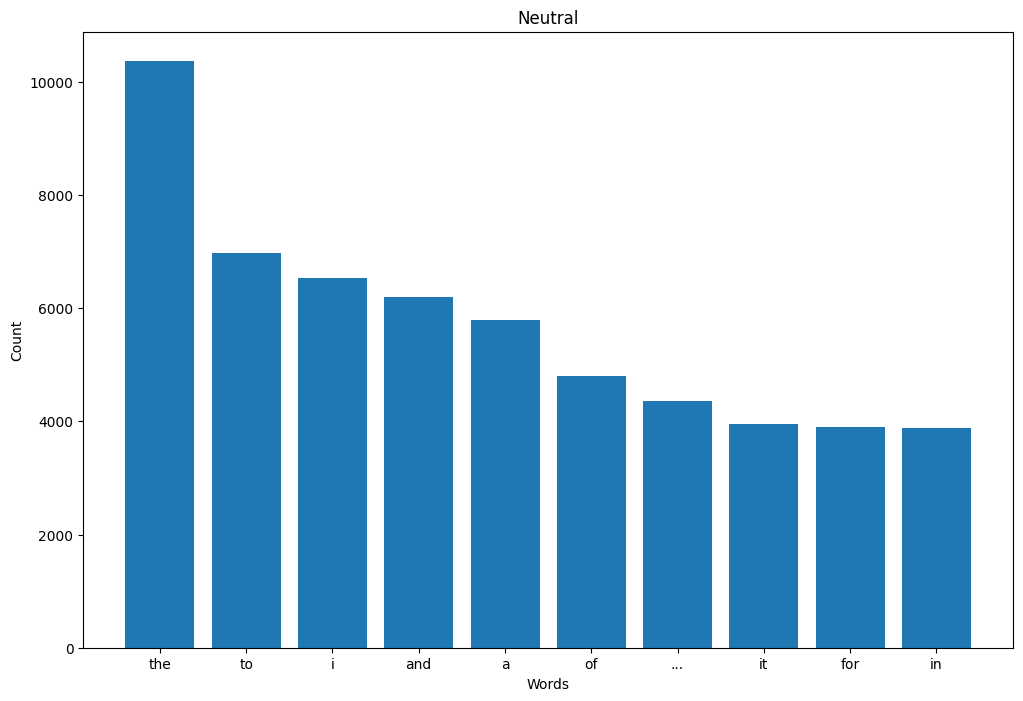

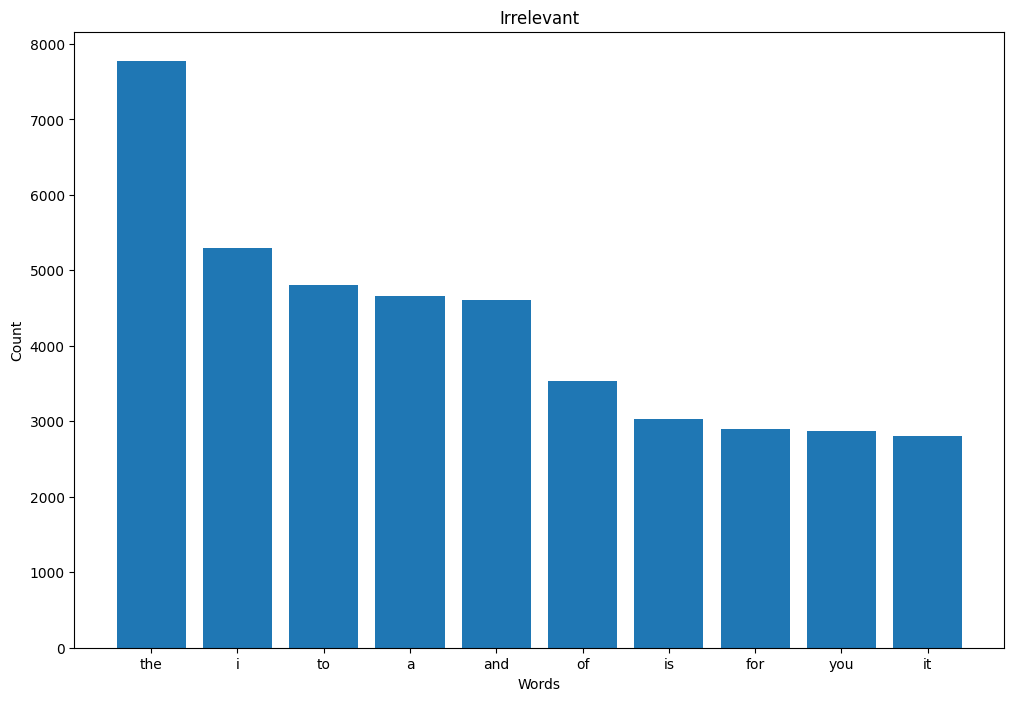

In [47]:
for index,i in enumerate(ls):
  plt.figure(figsize=(12, 8))
  plt.bar(i['Word'],i['Frequency'])
  plt.title(idx[index])
  plt.xlabel('Words')
  plt.ylabel('Count')
  plt.show()

##Model Performance Evaluation

In [48]:
y_pred = gnb.predict(X_test)

<Axes: >

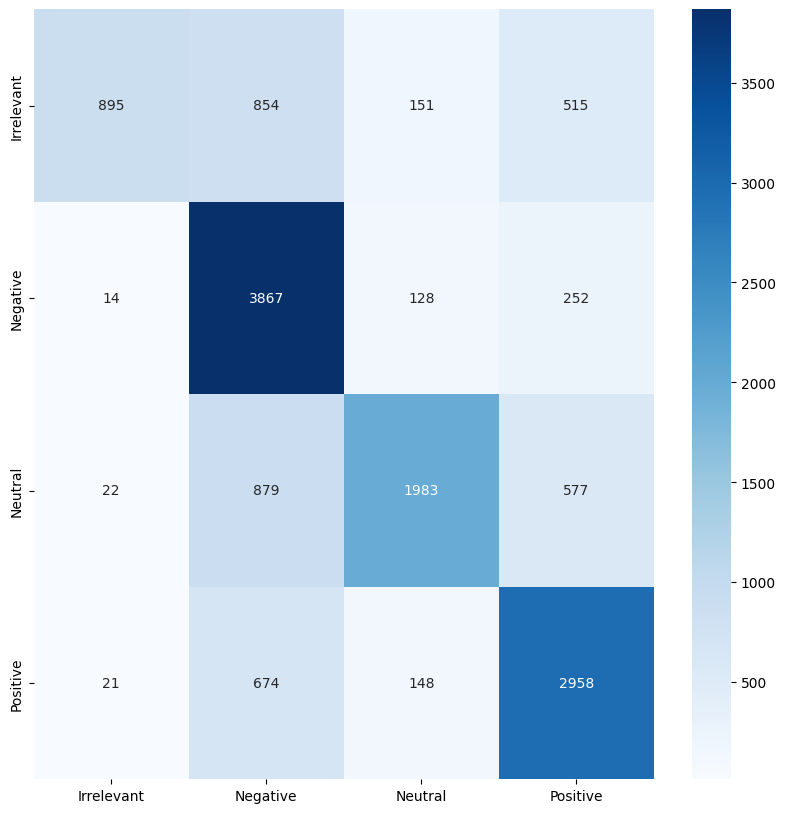

In [49]:
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labelMap.values(), yticklabels=labelMap.values())

In [50]:
y_train.info()
y_train_new = pd.DataFrame(y_train)
y_train_new

y_test_new = pd.DataFrame(y_test)

<class 'pandas.core.series.Series'>
Index: 55752 entries, 68618 to 15033
Series name: sentiment
Non-Null Count  Dtype
--------------  -----
55752 non-null  int64
dtypes: int64(1)
memory usage: 871.1 KB


In [51]:
dspn = ds[(ds["sentiment"]==1) | (ds["sentiment"]==3)]
dspn.head()

,id,topic,sentiment,comment,tokenized
0,2401,4,3,i am come to the border and i will kill you all,i am come to the border and i will kill you all
1,2401,4,3,im get on borderland and i will kill you all,im get on borderland and i will kill you all
2,2401,4,3,im come on borderland and i will murder you all,im come on borderland and i will murder you all
3,2401,4,3,im get on borderland 2 and i will murder you m...,im get on borderland 2 and i will murder you m...
4,2401,4,3,im get into borderland and i can murder you all,im get into borderland and i can murder you all


In [52]:
X_new = dspn["tokenized"]
y_new = pd.DataFrame(dspn["sentiment"])
y_new[y_new["sentiment"]==3]=0
#0 is Positive, 1 is negative

In [53]:
comment2 = feature_extraction.fit_transform(X_new)

In [54]:
X_train,X_test,y_train,y_test = train_test_split(comment2,y_new,test_size=0.2,random_state=50)

In [55]:
gnb.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [56]:
y_pred = gnb.predict(X_test)

In [57]:
precision, recall, thresholds = precision_recall_curve(y_test,y_pred)

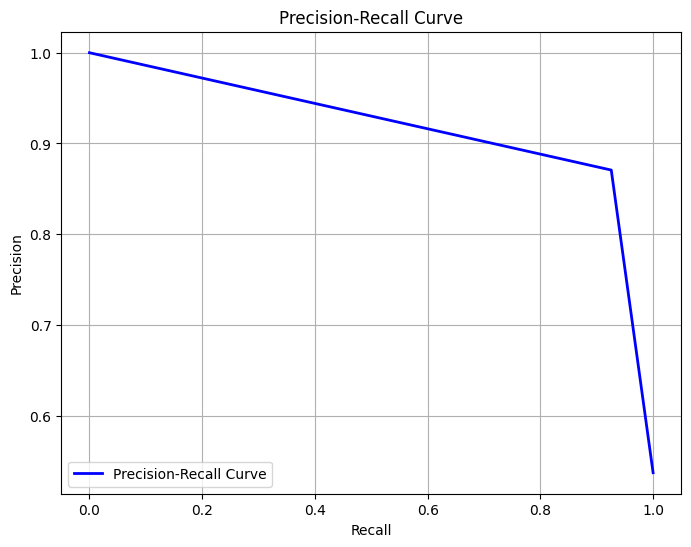

In [58]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve', color='blue', lw=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

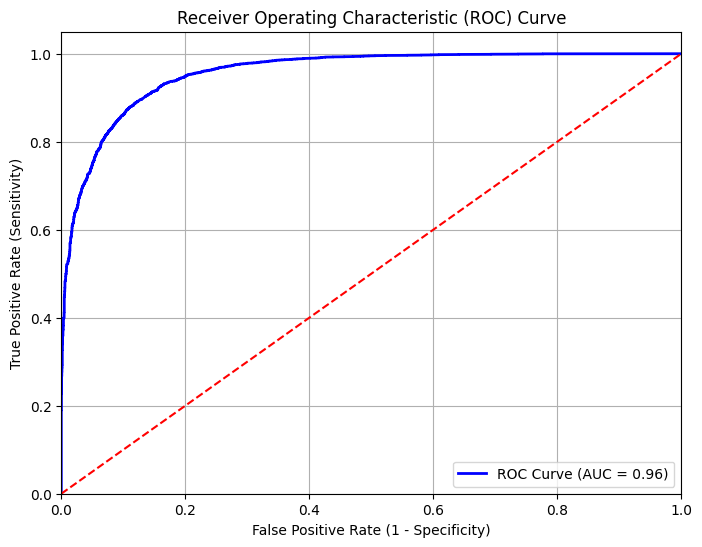

In [59]:
y_scores = gnb.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#Prediction with New Data

In [60]:
inp = str(input("Enter the twitter review"))

Enter the twitter reviewThe game was very bad and boring


##Processing Data

###Replacing Major Punctuations

In [61]:
inp.replace(',', '').replace('!', '').replace('.', '')

'The game was very bad and boring'

###Changing Text to Lowercase

In [62]:
inp.lower()

'the game was very bad and boring'

###Using Stemming to reduce text to base form

In [63]:
input=stemmer(inp)

In [64]:
inp

'The game was very bad and boring'

###Tokenization

In [65]:
inp=word_tokenize(inp)

In [66]:
inp = ' '.join(inp)

###Feature Extraction

In [67]:
test_comment=feature_extraction.transform(pd.Series(inp))

In [68]:
test_comment

<1x15066 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [69]:
y_pred = gnb.predict(test_comment)

##Output

In [70]:
print("Your twitter comment is",labelMap[y_pred[0]])

Your twitter comment is Negative


#Using Validation Dataset

In [71]:
df = pd.read_csv('/content/twitter_validation.csv')

In [72]:
df.isnull().sum()

3364                                                                                                                                                                                                                                                  0
Facebook                                                                                                                                                                                                                                              0
Irrelevant                                                                                                                                                                                                                                            0
I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣    0
dtype: i

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column                                                                                                                                                                                                                                              Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                              --------------  ----- 
 0   3364                                                                                                                                                                                                                                                999 non-null    int64 
 1   Facebook                                                                   

In [74]:
df.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [75]:
df.drop_duplicates(keep=False, inplace=True)

In [76]:
df=df.rename(columns={"3364":"id","Facebook":"topic","Irrelevant":"sentiment","I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣":"comment"})

In [77]:
df.head()

,id,topic,sentiment,comment
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [78]:
df["topic"].unique()

array(['Amazon', 'Microsoft', 'CS-GO', 'Google', 'FIFA', 'MaddenNFL',
       'TomClancysRainbowSix', 'AssassinsCreed', 'CallOfDuty', 'Dota2',
       'Verizon', 'NBA2K', 'Nvidia', 'GrandTheftAuto(GTA)',
       'RedDeadRedemption(RDR)', 'Hearthstone', 'ApexLegends',
       'Overwatch', 'PlayerUnknownsBattlegrounds(PUBG)', 'Borderlands',
       'PlayStation5(PS5)', 'johnson&johnson', 'Fortnite',
       'Xbox(Xseries)', 'CallOfDutyBlackopsColdWar', 'Facebook',
       'HomeDepot', 'Cyberpunk2077', 'TomClancysGhostRecon',
       'WorldOfCraft', 'LeagueOfLegends', 'Battlefield'], dtype=object)

In [79]:
df["comment"].isnull()

0      False
1      False
2      False
3      False
4      False
       ...  
994    False
995    False
996    False
997    False
998    False
Name: comment, Length: 999, dtype: bool

In [80]:
encoder = LabelEncoder()
df["sentiment"] = encoder.fit_transform(df["sentiment"])
df["topic"] = encoder.fit_transform(df["topic"])

In [81]:
df.head()

,id,topic,sentiment,comment
0,352,0,2,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,19,1,@Microsoft Why do I pay for WORD when it funct...
2,4371,5,1,"CSGO matchmaking is so full of closet hacking,..."
3,4433,13,2,Now the President is slapping Americans in the...
4,6273,10,1,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [82]:
df["comment"].isnull().sum()

0

In [83]:
df=df.dropna()

In [84]:
df

,id,topic,sentiment,comment
0,352,0,2,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,19,1,@Microsoft Why do I pay for WORD when it funct...
2,4371,5,1,"CSGO matchmaking is so full of closet hacking,..."
3,4433,13,2,Now the President is slapping Americans in the...
4,6273,10,1,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,14,0,⭐️ Toronto is the arts and culture capital of ...
995,4359,5,0,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,4,3,Today sucked so it’s time to drink wine n play...
997,8069,19,3,Bought a fraction of Microsoft today. Small wins.


In [85]:
df["comment"] = df["comment"].replace(',', '').replace('!', '').replace('.', '')

In [86]:
df["comment"]

0      BBC News - Amazon boss Jeff Bezos rejects clai...
1      @Microsoft Why do I pay for WORD when it funct...
2      CSGO matchmaking is so full of closet hacking,...
3      Now the President is slapping Americans in the...
4      Hi @EAHelp I’ve had Madeleine McCann in my cel...
                             ...                        
994    ⭐️ Toronto is the arts and culture capital of ...
995    tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996    Today sucked so it’s time to drink wine n play...
997    Bought a fraction of Microsoft today. Small wins.
998    Johnson & Johnson to stop selling talc baby po...
Name: comment, Length: 999, dtype: object

In [87]:
df["comment"]=df["comment"].str.lower()

In [88]:
ps = PorterStemmer()

def stemmer(word):
    word = word.lower()
    word = word_tokenize(word)

    full_txt = []
    for i in word:
        if i not in "!@#$%^&*()-_=+`~;:'\",<.>/?|":
            full_txt.append(ps.stem(i))
    return ' '.join(full_txt)


In [89]:
df["comment"]=df["comment"].apply(stemmer)

In [90]:
df.head()

,id,topic,sentiment,comment
0,352,0,2,bbc news amazon boss jeff bezo reject claim co...
1,8312,19,1,microsoft whi do i pay for word when it functi...
2,4371,5,1,csgo matchmak is so full of closet hack it 's ...
3,4433,13,2,now the presid is slap american in the face th...
4,6273,10,1,hi eahelp i ’ ve had madelein mccann in my cel...


In [91]:
df['tokenized'] = df['comment'].apply(word_tokenize)

In [92]:
df.head()

,id,topic,sentiment,comment,tokenized
0,352,0,2,bbc news amazon boss jeff bezo reject claim co...,"[bbc, news, amazon, boss, jeff, bezo, reject, ..."
1,8312,19,1,microsoft whi do i pay for word when it functi...,"[microsoft, whi, do, i, pay, for, word, when, ..."
2,4371,5,1,csgo matchmak is so full of closet hack it 's ...,"[csgo, matchmak, is, so, full, of, closet, hac..."
3,4433,13,2,now the presid is slap american in the face th...,"[now, the, presid, is, slap, american, in, the..."
4,6273,10,1,hi eahelp i ’ ve had madelein mccann in my cel...,"[hi, eahelp, i, ’, ve, had, madelein, mccann, ..."


In [93]:
df['tokenized'] = df['tokenized'].apply(lambda tokens: ' '.join(tokens))

In [94]:
token = df["tokenized"]

In [95]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# feature_extraction = TfidfVectorizer()
comment1=feature_extraction.fit_transform(token)

In [96]:
df.head()

,id,topic,sentiment,comment,tokenized
0,352,0,2,bbc news amazon boss jeff bezo reject claim co...,bbc news amazon boss jeff bezo reject claim co...
1,8312,19,1,microsoft whi do i pay for word when it functi...,microsoft whi do i pay for word when it functi...
2,4371,5,1,csgo matchmak is so full of closet hack it 's ...,csgo matchmak is so full of closet hack it 's ...
3,4433,13,2,now the presid is slap american in the face th...,now the presid is slap american in the face th...
4,6273,10,1,hi eahelp i ’ ve had madelein mccann in my cel...,hi eahelp i ’ ve had madelein mccann in my cel...


In [97]:
comment

<69690x25432 sparse matrix of type '<class 'numpy.float64'>'
	with 1167802 stored elements in Compressed Sparse Row format>

In [98]:
y1=df["sentiment"]

In [99]:
X1_train,X1_test,y1_train,y1_test = train_test_split(comment1,y1,test_size=0.2,random_state=50)

In [100]:
gnb1 = MultinomialNB()
gnb1.fit(X1_train,y1_train)

MultinomialNB()

In [101]:
gnb1.score(X1_train,y1_train)

0.8560700876095119

In [102]:
gnb1.score(X1_test,y1_test)

0.535

In [103]:
cv = cross_val_score(gnb1,X1_train,y1_train)
cv

array([0.5125    , 0.475     , 0.4125    , 0.5375    , 0.49685535])

In [104]:
cross_val_score(gnb1,X1_test,y1_test)

array([0.4  , 0.475, 0.4  , 0.425, 0.45 ])

In [105]:
gnb1.score(comment1,y1)

0.7917917917917918